<a href="https://colab.research.google.com/github/poojan14/AIMS/blob/main/AIMS_air_pressure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pydrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [ ]:
download = drive.CreateFile({'id':'1UAdVNJYNEyUU3iGMQoQACNjrojqOHhVM'})


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline

import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping


In [ ]:
download.GetContentFile('AIMS.csv')
import pandas as pd
import numpy as np
df=pd.read_csv('AIMS.csv')


In [ ]:
df.head(10)

,date time,date,time,seconds since 1970,Humidity,Water_Temperature,Air_Temperature,Air_Pressure
0,2020-08-06T00:00:00+1000,06-08-2020,00:00:00,1600000000.0000,73.0000,22.5700,22.2000,1014.0000
1,2020-08-06T00:10:00+1000,06-08-2020,00:10:00,1600000000.0000,71.8000,22.5700,22.3000,1013.7000
2,2020-08-06T00:20:00+1000,06-08-2020,00:20:00,1600000000.0000,71.9000,22.5800,22.3000,1013.8000
3,2020-08-06T00:30:00+1000,06-08-2020,00:30:00,1600000000.0000,71.1000,22.5700,22.2000,1013.5000
4,2020-08-06T00:40:00+1000,06-08-2020,00:40:00,1600000000.0000,73.9000,22.5600,22.2000,1013.6000
5,2020-08-06T00:50:00+1000,06-08-2020,00:50:00,1600000000.0000,73.8000,22.5600,22.3000,1013.5000
6,2020-08-06T01:00:00+1000,06-08-2020,01:00:00,1600000000.0000,74.9000,22.5600,22.3000,1013.3000
7,2020-08-06T01:10:00+1000,06-08-2020,01:10:00,1600000000.0000,73.2000,22.5600,22.3000,1013.3000
8,2020-08-06T01:20:00+1000,06-08-2020,01:20:00,1600000000.0000,71.6000,22.5600,22.3000,1013.3000
9,2020-08-06T01:30:00+1000,06-08-2020,01:30:00,1600000000.0000,74.2000,22.5600,22.3000,1013.3000


In [ ]:
df.shape

(22454, 8)

In [ ]:
df.isnull().sum()

date time             0
date                  0
time                  0
seconds since 1970    0
Humidity              0
Water_Temperature     0
Air_Temperature       0
Air_Pressure          0
dtype: int64

In [ ]:
dataset = df.Air_Pressure.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)


In [ ]:
# reshape into X=t and Y=t+1
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)


In [ ]:
X_train.shape


(17932, 30)

In [ ]:
Y_train.shape


(17932,)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=20, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

# Training Phase
model.summary()


Epoch 1/20
257/257 [==============================] - 2s 3ms/step - loss: 0.0410 - val_loss: 0.0022
Epoch 2/20
257/257 [==============================] - 0s 1ms/step - loss: 0.0064 - val_loss: 0.0016
Epoch 3/20
257/257 [==============================] - 1s 2ms/step - loss: 0.0044 - val_loss: 0.0013
Epoch 4/20
257/257 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0014
Epoch 5/20
257/257 [==============================] - 1s 2ms/step - loss: 0.0037 - val_loss: 0.0014
Epoch 6/20
257/257 [==============================] - 1s 2ms/step - loss: 0.0038 - val_loss: 0.0017
Epoch 7/20
257/257 [==============================] - 1s 2ms/step - loss: 0.0037 - val_loss: 0.0020
Epoch 8/20
257/257 [==============================] - 1s 2ms/step - loss: 0.0036 - val_loss: 0.0023
Epoch 9/20
257/257 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0028
Epoch 10/20
257/257 [==============================] - 0s 2ms/step - loss: 0.0040 - val_loss: 0.0031

In [ ]:
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))


Train Mean Absolute Error: 0.8082337469691033
Train Root Mean Squared Error: 1.071669100928388
Test Mean Absolute Error: 0.9612309047720227
Test Root Mean Squared Error: 1.047175903791771


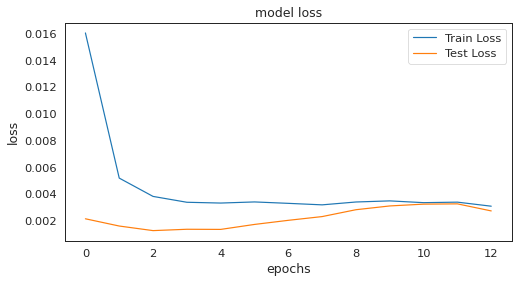

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();


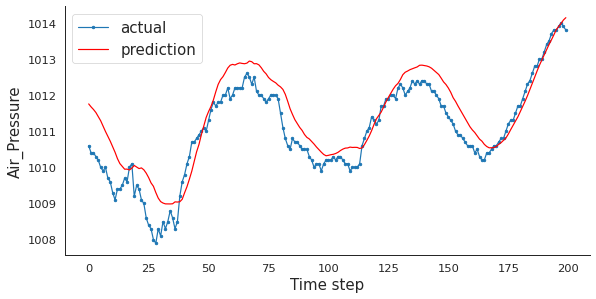

In [ ]:
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Air_Pressure', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();
